In [140]:
from decimal import Decimal
import time 
import decimal
math = decimal.Context()
import numpy 
import random
%matplotlib inline
import matplotlib
import pandas

In [2]:
class Token:       
    def __init__(self, _name = ""):
        self.balances = {}
        self.totalSupply = 0
        self._name = _name
    
    def mint(self, address, amount):
        assert(amount > 0)
        self.balances[address] = self.balances.get(address, 0) + amount
        self.totalSupply += amount
        return True
        
    def burn(self, address, amount):
        assert(amount > 0)
        if self.balances[address] < amount:
            raise Exception("burn: Cannot burn more value than present at address")
        self.balances[address] = self.balances.get(address, 0) - amount
        self.totalSupply -= amount
        return True
    
    def balanceOf(self, address):
        return self.balances.get(address, 0)
    
    def name(self):
        return self._name
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        # always round
        if self.balanceOf(sender) >= amount:
            self.balances[sender] = self.balances.get(sender, 0) - amount
            self.balances[recipient] = self.balances.get(recipient, 0) + amount    
            return True
        else:
            raise Exception("transferFrom: Cannot transfer more than balance")

In [3]:
# Basic test of Token class

token = Token()
token.mint("A", 5)
assert(token.balanceOf("A") == 5)

token.transferFrom("A", "B", 3)
assert(token.balanceOf("B") == 3)
assert(token.balanceOf("A") == 2)

token.transferFrom("A", "C", 2)
assert(token.balanceOf("A") == 0)
assert(token.balanceOf("C") == 2)

In [23]:
class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        self.block += 1
        self.timestamp += 15
    
    def updateTimestamp(self, _timestamp):
        self.timestamp = _timestamp
    
    def now(self):
        return self.timestamp


class InterestToken(Token):
    # rate is a yearly rate, converted to a rate compounded per second
    def __init__(self, _name, _blockchain, rate, _rateAccumulator):
        Token.__init__(self, _name)
        self.blockchain = _blockchain
        self.lastUpdate = self.blockchain.now()
        self.rateAccumulator = _rateAccumulator
        # 31622400 is the number of seconds in a year
        self.rate = math.power(1 + Decimal(rate), 1/Decimal(31622400))  
        self.interestRateLimit = math.power(1 + Decimal(2), 1/Decimal(31622400)) 
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.rateAccumulator
    
    def transferUnderlying(self, sender, recipient, amount):
        value = amount / self.rateAccumulator
        return self.transferFrom(sender, recipient, value)
        
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.lastUpdate = now
    
    def updateRate(self, update):
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
        if self.rate > self.interestRateLimit:
            self.rate = self.interestRateLimit
    
    def yearlyRate(self):
        return math.power(self.rate, Decimal(31622400)) - 1
    
    def mintInUnderlying(self, address, amount):
        return self.mint(address, amount/self.rateAccumulator)
        
    def burnInUnderlying(self, address, amount):
        return self.burn(address, amount/self.rateAccumulator)

In [24]:
# Basic tests of Interest Token Class

chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
chain.updateTimestamp(31622400)
token.accrueInterest()
token.balanceOfUnderlying("A")
assert(int(token.balanceOfUnderlying("A")) == 1020)

In [25]:
chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
# Note that the per second rates are multiplied, not added
token.updateRate(.001)
token.updateRate(.001)
token.updateRate(-.001)
token.updateRate(.001)
token.updateRate(.001)
#print(token.yearlyRate())
chain.updateTimestamp(31622400)
#print(token.rate)
token.accrueInterest()
assert(int(token.balanceOfUnderlying("A")) == 1023)

In [89]:

class QX:
    def __init__(self, _uToken : Token , _sToken : Token):
        self.uToken = _uToken
        self.pyToken = _sToken
        self.underlying = 0
        self.synthetic  = 0   # denominated in pyTokens
        self.address = '0xQX_' + _uToken.name()
        self.book = dict()

    # amount is denominated in underlying
    def sellUnderlying(self, sender, amount):
        if amount < 0:
            raise Exception("sellUnderlying: Cannot sell a negative amount. Amount: {}".format(amount))
        result = self.uToken.transferFrom(sender, self.address, amount)
        if result:
            self.underlying += amount
            result = self.pyToken.mintInUnderlying( self.address, amount)
            if not result:
                raise Exception("sellUnderlying: Minting pyTokens failed. Amount: {}".format(amount))
            result = self.pyToken.transferUnderlying(self.address, sender, amount)
            if not result:
                raise Exception("sellUnderlying: Token transfer out failed. Amount: {}".format(amount))
        else:
            raise Exception("sellUnderlying: Token transfer in failed. Amount: {}".format(amount))

    def addOrder(self, sender, amount, height):
        if not sender in self.book:
            self.book[sender] = []
        self.book[sender].append({'amount': amount, 'height': height})
    
    def sellPyToken(self, sender, amount):
        if amount < 0:
            raise Exception("sellPyToken: Cannot sell a negative amount. Amount: {}".format(amount))
        result = self.pyToken.burnInUnderlying(sender, amount)
        if result:
            newHeight = self.synthetic + amount
            if self.underlying >= self.synthetic:
                if newHeight < self.underlying:
                    # We can pay out everything
                    result = self.uToken.transferFrom(self.address, sender, amount)
                    if not result:
                        raise Exception("sellPyToken: Token transfer out failed. Amount: {}".format(amount))   
                else:
                    # We can pay out something
                    amountToPay = self.underlying - self.synthetic
                    amountRemaining = amount - amountToPay
                    self.addOrder(sender, amountRemaining, newHeight)
                    result = self.uToken.transferFrom(self.address, sender, amountToPay)
                    if not result:
                        raise Exception("sellPyToken: Token transfer out failed. Amount: {}".format(amount))                    
            else:
                #cannot pay out
                self.addOrder(sender, amount, newHeight)
            self.synthetic = newHeight
        else:
            raise Exception("sellPyToken: Token transfer in failed. Amount: {}".format(amount))
    
    def withdrawUnderlying(self, sender):
        if not sender in self.book:
            return False
        for order in self.book[sender]:
            if self.underlying >= order['height']:
                result = self.uToken.transferFrom(self.address, sender, order['amount'])
                if not result:
                    raise Exception("withdrawUnderlying: Token transfer out failed. Amount: {}".format(order['amount']))
                self.book[sender].remove(order)
    
    def measureImbalance(self):
        return self.underlying - self.synthetic  


In [90]:
# Test out QX
chain = blockchain(1,1)
uToken = Token("u")
sToken = InterestToken("py", chain, 0,1)
queue = QX(uToken, sToken)
uToken.mint("A", 1000)
sToken.mint("B", 1000)

# Test 1
queue.sellUnderlying("A", 100)
queue.sellPyToken("B", 100)
queue.withdrawUnderlying("A") # should not do anything
queue.withdrawUnderlying("B") # should not do anything
assert(uToken.balanceOf("A") ==  900)
assert(uToken.balanceOf("B") ==  100)
assert(sToken.balanceOf("A") ==  100)
assert(sToken.balanceOf("B") ==  900)

#Test 2
queue.sellUnderlying("A", 100)
queue.sellPyToken("B", 150)
queue.withdrawUnderlying("A") # should not do anything
queue.withdrawUnderlying("B") # should not do anything
assert(uToken.balanceOf("A") ==  800)
assert(uToken.balanceOf("B") ==  200)
assert(sToken.balanceOf("A") ==  200)
assert(sToken.balanceOf("B") ==  750)

#Test 3
queue.sellUnderlying("A", 100)
queue.withdrawUnderlying("B")
queue.withdrawUnderlying("A") 

assert(uToken.balanceOf("A") ==  700)
assert(uToken.balanceOf("B") ==  250)
assert(sToken.balanceOf("A") ==  300)
assert(sToken.balanceOf("B") ==  750)

In [91]:
# Further Test out Queueball
chain = blockchain(1,1)
uToken = Token("u")
sToken = InterestToken("py", chain, 0,1)
queue = QX(uToken, sToken)
uToken.mint("C", 1000)
uToken.mint("D", 1000)
uToken.mint("E", 1000)
sToken.mint("C", 1000)
sToken.mint("D", 1000)
sToken.mint("E", 1000)
# You can permute the following in any order and the tests should still pass

queue.sellUnderlying("C", 100)
queue.sellUnderlying("E", 200)
queue.sellUnderlying("D", 200)
queue.sellPyToken("D", 300)
queue.sellUnderlying("E", 300)
queue.sellPyToken("E", 100)
queue.sellPyToken("E", 400)

#######
queue.withdrawUnderlying("C")
queue.withdrawUnderlying("D")
queue.withdrawUnderlying("E")
assert(uToken.balanceOf("C") ==  900)
assert(uToken.balanceOf("D") ==  1100)
assert(uToken.balanceOf("E") ==  1000)
assert(sToken.balanceOf("C") ==  1100)
assert(sToken.balanceOf("D") ==  900)
assert(sToken.balanceOf("E") ==  1000)

In [92]:
class Oracle:
    def __init__(self, _tokenA, _tokenB):
        self.tokenA = _tokenA
        self.tokenB = _tokenB
        # Price is stored in terms of TokenB
        self.price = 0 
    
    # Assumes price is in terms of Token B
    def currentPrice(self):
        return self.price
    
    # Assumes price is in terms of Token B
    def setPrice(self, price):
        self.price = price
        
    def setPriceInToken(self, token, price):
        if token == self.tokenA:
            self.price = 1 / price
        else:
            self.price = price
            
    def getPriceInToken(self, token):
        if token == self.tokenA:
            return Decimal('1') /self.price
        else:     
            return self.price

In [93]:
# Simple Test of Oracle
ETH = Token("ETH")
DAI = Token("DAI")
oracle = Oracle(ETH, DAI)
oracle.setPriceInToken(DAI, Decimal('100'))
assert(oracle.getPriceInToken(DAI) == Decimal('100'))
assert(oracle.getPriceInToken(ETH) == (Decimal('1')/Decimal('100')))

In [94]:
# Issues:
# 1. it is possible to pay out more pyTokens that is offset by debt


class pyToken (InterestToken):
    def __init__(self, _blockchain, _underlying : Token, _oracle):  
        super().__init__("", _blockchain, Decimal('0'), Decimal('1'))
        self.underlying = _underlying
        self._name = "py" + self.underlying.name()
        self.cdp = {self.underlying.name(): {}}
        self.tokens = {}
        self.address = '0x' + self.name()
        # oracle for the pyToken <> pyToken pair
        self.oracle = _oracle
        self.qx = 0
        self.interestUpdateAmount = Decimal('0.0001')
        self.collateralizationRatio = Decimal('1.7')
        self.debtAccumulator = self.rateAccumulator
        self.debtRate = self.rate
        # bonus factor when liquidating
        self.bonus = Decimal('1.1')
        self.adjustmentFreeWindow = Decimal('0.1')
        
    # Admin Functions
    def setPair(self, _pairedpyToken : InterestToken):
        self.pairedpyToken = _pairedpyToken  
        self.tokens[self.pairedpyToken.name()] = self.pairedpyToken
        self.cdp[self.pairedpyToken.name()] = {}
        
    def setQueueExchange(self,exchange):
        self.qx = exchange
        
    def addCollateralType(self, token, oracle):
        self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        self.cdp[token.name()] = {}
    
    # User Functions
    def addCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        result = self.tokens[token]['token'].transferFrom(address, self.address, amount)
        if result:
            if address not in self.cdp[token]:
                self.cdp[token][address] = {'amount':amount, 'debt':Decimal('0')}
            else:
                self.cdp[token][address]['amount'] += amount
        else:
            return False
      
    def withdrawCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        # check oracle price
        price = self.oracle.currentPrice()
        minimumCollateral = self.oracle.currentPrice() * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator - amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("withdrawCollateral: Insufficient free capital to withdraw")
        result = self.tokens[token].transferFrom(self.address, address, amount)
        if result:
            self.cdp[token][address]['amount'] = self.cdp[token][address]['amount'] - amount
    
    # accrue for both debt and interest
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.debtAccumulator = math.power(self.debtRate, total_time) * self.debtAccumulator
            self.lastUpdate = now
        
    # updateRate for both debt and interest
    # this contract implicity assumes that this is called every block
    def updateRate(self, update):
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        self.debtRate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
        if self.rate > self.interestRateLimit:
            self.rate = self.interestRateLimit
        
    
    def getCollateral(self, token, address):
        return self.cdp[token][address]['amount'] 
    
    def getDebt(self, token, address):
        return self.cdp[token][address]['debt'] 
    
    def debtInUnderlying(self, token, address):
        return self.cdp[token][address]['debt'] * self.debtAccumulator
    
    # borrow against a particular tokens worth of collateral
    def borrow(self, token, address, amount):
        if token not in self.tokens.keys():
            raise Exception("Borrow: Token not found")
        if amount < 0:
            raise Exception("Borrow: Cannot borrow negative amounts")
            self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        minimumCollateral = ( 1 / price) * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator + amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("Borrow: Insufficient collateral Available: {} Minimum Needed: {}".format(self.cdp[token][address]['amount'], minimumCollateral))
        # Add debt
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] + Decimal(amount) / self.debtAccumulator
        # Add borrow
        self.mintInUnderlying(address, amount)
        try:
            assert(self.balanceOfUnderlying(address) >= amount)
        except:     
            print("amount minted: {} balance: {}".format(amount, self.balanceOfUnderlying(address)))
        
    def maximumBorrow(self, token, address):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.cdp[token][address]['amount'] * price * \
                         (1 / self.collateralizationRatio) 
        return maximumBorrow
    

       
    def liquidate(self, token, addressToLiquidate, LiquidatorAddress, amount):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.maximumBorrow(token, addressToLiquidate)
        debt = self.debtInUnderlying(token, addressToLiquidate)
        if maximumBorrow < debt:
            # We need to liquidate
            if amount < debt:
                raise Exception("liquidate: Must liquidate entire CDP at once")
            availableFunds = self.balanceOfUnderlying(LiquidatorAddress)
            if availableFunds < amount:
                raise Exception("liquidate: Insufficient funds to liquidate")
            
            collateralToLiquidator = debt*self.bonus/price
            if collateralToLiquidator > self.cdp[token][addressToLiquidate]['amount']:
                raise Exception("liquidate: CDP liquidated while undercollateralized. Owed to Liquidator: {} Available: {}".format(collateralToLiquidator, self.cdp[token][addressToLiquidate]['amount']))
            # Only burn amount of debt--it's possible to specify more than debt and have liquidate succeed
            self.burn(LiquidatorAddress, self.getDebt(token, addressToLiquidate))
            # Transfer liquidated funds to Liquidator
            self.tokens[token]['token'].transferFrom(self.address, LiquidatorAddress, collateralToLiquidator)
            # Debit CDP account 
            self.cdp[token][addressToLiquidate]['amount'] -= collateralToLiquidator
            # Wipe Debt
            self.cdp[token][addressToLiquidate]['debt'] = 0
        else:
            raise Exception("liquidate: Cannot liquidate a working CDP")
        
    # Position in a particular collateral token
    def position(self, token, address):
        return self.cdp[token][address]
    
    def repay(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        if amount < 0:
            return False        
        if amount < self.debtInUnderlying(token, address):
            raise Exception("Cannot repay more than available debt")
        # Decrease debt
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] - Decimal(amount) / self.debtAccumulator
        assert(self.cdp[token][address]['debt'] >= 0)
        self.burnInUnderlying(address, amount)
        
        
    def updateRates(self):
        if self.totalSupply == 0:
            return
        imbalance = self.qx.measureImbalance()
        if imbalance == 0:
            return      
        normalized = imbalance / self.totalSupply 
        if imbalance > self.adjustmentFreeWindow:
            # lower interest rate
            self.updateRate(-self.interestUpdateAmount)
        elif imbalance < -self.adjustmentFreeWindow:
            # raise interest rate
            self.updateRate(self.interestUpdateAmount)
    
        
        

In [95]:
# Basic test of pyToken class

chain = blockchain(1,1)
BAT = Token("BAT")
DAI = Token("DAI")
oracleA = Oracle(BAT, DAI)

collateral = Token("Collateral")
oracleC = Oracle(collateral, BAT)
oracleC.setPrice(Decimal(1000000))
pyBAT = pyToken(chain, BAT, oracleA)
pyBAT.addCollateralType(collateral, oracleC)
qx = QX(BAT , pyBAT)
pyBAT.setQueueExchange(qx)

oracleC.setPrice(Decimal(1000))
BAT.mint("A", Decimal('1000'))
collateral.mint("B", Decimal('1000'))
pyBAT.addCollateral("Collateral", "B", Decimal('100'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
pyBAT.repay("Collateral", "B", Decimal('10'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
assert(pyBAT.balanceOf("B") == Decimal('10'))


In [96]:
# Liquidation Test
oracleC.getPriceInToken(collateral)
debt = pyBAT.debtInUnderlying("Collateral", "B")
maxBorrow = pyBAT.maximumBorrow("Collateral", "B")
pyBAT.borrow("Collateral", "B", maxBorrow-debt)
# Now make repo undercollateralized
oracleC.setPriceInToken(BAT, Decimal(900))
pyBAT.mint("A", Decimal('100000'))
pyBAT.liquidate("Collateral", "B", "A", pyBAT.debtInUnderlying("Collateral", "B"))
assert(pyBAT.debtInUnderlying("Collateral", "B") == Decimal('0'))
assert(collateral.balanceOf("A") == Decimal('71.89542483660130718954248367'))
assert(pyBAT.getCollateral("Collateral", "B") + collateral.balanceOf("A") == Decimal('100.0000000000000000000000000'))

In [97]:
# External market that provides "infinite" liquidity
class ReferenceExchange:
    def __init__(self):
        self.tokenPairs = {}
        self.address = "0xReferenceExchange"
    
    # Add pair. The price is the number of tokenB per tokenA
    def addPair(self, tokenA, tokenB):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        
        if firstToken not in self.tokenPairs.keys():
            self.tokenPairs[firstToken] = {secondToken: {}}
        self.tokenPairs[firstToken][secondToken] = {'Base':tokenA, 'Quote':tokenB, 'Price':Decimal('0')}  
        
        # mint a lot of tokens for both sides
        tokenA.mint(self.address, Decimal(1000000000))
        tokenB.mint(self.address, Decimal(1000000000))

    
    def updatePairPrice(self, tokenA, tokenB, price):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        self.tokenPairs[firstToken][secondToken]['Price'] = price
    
    def trade(self, tokenA, tokenB, tokenAAmount, address):
        # transfer in tokenA
        result = tokenA.transferFrom(address, self.address, tokenAAmount)
        if result: 
            firstToken = tokenB.name()
            secondToken = tokenA.name()
            if tokenA.name() > tokenB.name():
                firstToken = tokenA.name()
                secondToken = tokenB.name()
            pair = self.tokenPairs[firstToken][secondToken]
            multiplier = 0
            if pair['Quote'].name() == tokenB.name():
                multiplier = pair['Price']
            else:
                multiplier = 1/pair['Price']
            # calculate amount of tokenB to send
            tokens_to_send = tokenAAmount * multiplier
            # send tokenB to address
            transferR = tokenB.transferFrom(self.address, address, tokens_to_send)
            return (tokens_to_send, transferR)
        else:
            raise Exception("Trade: Token transfer failed")

In [98]:
class Interface:
    
    def __init__(self, _chain : blockchain, _uTokenA : Token, _uTokenB : Token, oracle):
        self.A = _uTokenA
        self.B = _uTokenB
        self.chain = _chain
        self.oracle = oracle
        self.pyA = pyToken(_chain, self.A, oracle)
        self.pyB = pyToken(_chain, self.B, oracle)
        self.pyA.setPair(self.pyB)
        self.pyB.setPair(self.pyA)
        self.qxA = QX(self.A , self.pyA)
        self.qxB = QX(self.B , self.pyB)
        self.pyA.setQueueExchange(self.qxB)
        self.pyB.setQueueExchange(self.qxA)
        # Add "ETH" as acceptable collateral
        self.eth = Token("ETH")
        self.ethAOracle = Oracle(self.eth, self.A)
        self.ethBOracle = Oracle(self.eth, self.B)
        self.ethAOracle.setPrice(Decimal('100'))
        self.ethBOracle.setPrice(Decimal(100/oracle.currentPrice()))
        self.pyA.addCollateralType(self.eth, self.ethAOracle)
        self.pyB.addCollateralType(self.eth, self.ethBOracle)
        self.ref = ReferenceExchange()
        self.ref.addPair(self.eth, self.A)
        self.ref.updatePairPrice(self.eth, self.A, self.ethAOracle.currentPrice())
        self.ref.addPair(self.eth, self.B)
        self.ref.updatePairPrice(self.eth, self.B, self.ethBOracle.currentPrice())
        
    def updateInterestRates(self):
        self.pyA.updateRates()
        self.pyB.updateRates()
        self.pyA.accrueInterest()
        self.pyB.accrueInterest()
    
    def eachBlock(self):
        self.chain.incrementBlock()
        self.updateInterestRates()
        


## Simulate


In [157]:
chain = blockchain(1,1)
oracle.setPrice(Decimal('2'))
tokenA = Token("TokenA")
tokenB = Token("TokenB")
oracle = Oracle(tokenA, tokenB)
oracle.setPrice(Decimal('1'))
interface = Interface(chain, tokenA, tokenB, oracle)

interface.A.mint("HODL", Decimal(10000))
interface.B.mint("HODL", Decimal(10000))
interface.eth.mint("BU", Decimal(1000))
interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

price = interface.ethAOracle.getPriceInToken(interface.A)
borrow = (Decimal(50) * price) / (interface.pyA.collateralizationRatio )
interface.pyA.borrow("ETH", "BU", borrow)

priceB = interface.ethBOracle.getPriceInToken(interface.B)
borrowB = (Decimal(50) * priceB) / (interface.pyB.collateralizationRatio )
interface.pyB.borrow("ETH", "BU", borrowB)

In [158]:
interface.pyA.position("ETH", "BU")

{'amount': Decimal('100'), 'debt': Decimal('2941.176470588235294117647059')}

In [159]:
interface.pyB.position("ETH", "BU")

{'amount': Decimal('100'), 'debt': Decimal('2941.176470588235294117647059')}

In [160]:
interface.qxA.sellPyToken("BU", Decimal('1000'))
interface.qxB.sellPyToken("BU", Decimal('1000'))

In [161]:
ratesA = []
ratesB = []

In [162]:
for i in range(100):
    ratesA.append(float(interface.pyA.yearlyRate()))
    ratesB.append(float(interface.pyB.yearlyRate()))
    interface.eachBlock()

In [163]:
interface.pyA.yearlyRate()

Decimal('0.010049662091295649505982921')

In [164]:
interface.qxA.sellUnderlying("HODL", Decimal('1000'))
interface.qxB.sellUnderlying("HODL", Decimal('1000'))

In [165]:
for i in range(100):
    ratesA.append(float(interface.pyA.yearlyRate()))
    ratesB.append(float(interface.pyB.yearlyRate()))
    interface.eachBlock()

In [166]:
# yearlyRate should remain unchanged
interface.pyA.yearlyRate()

Decimal('0.010049662091295649505982921')

In [167]:
interface.qxA.sellUnderlying("HODL", Decimal('1000'))
interface.qxB.sellUnderlying("HODL", Decimal('1000'))

In [168]:
for i in range(100):
    ratesA.append(float(interface.pyA.yearlyRate()))
    ratesB.append(float(interface.pyB.yearlyRate()))
    interface.eachBlock()

In [169]:
# yearlyRate should remain unchanged
interface.pyA.yearlyRate()

Decimal('0')

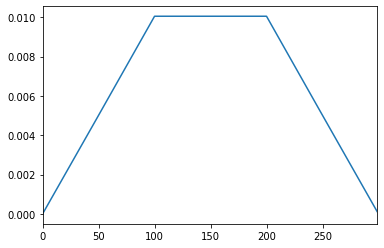

In [170]:
%matplotlib inline
import matplotlib
pandas.Series(ratesB).plot()